In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
import streamlit as st

In [4]:
df = pd.read_csv(r"C:\Users\rosel\Downloads\New folder\Classifying Network Traffic\DDos.pcap_ISCX.csv", low_memory=False)

In [5]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df.columns = df.columns.str.strip()

In [7]:
df['Label'].value_counts()

Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

In [8]:
def is_running_in_streamlit():
    try:
        import streamlit.runtime.scriptrunner.script_run_context as st_context
        return st_context.get_script_run_ctx() is not None
    except:
        return False

in_streamlit = is_running_in_streamlit()

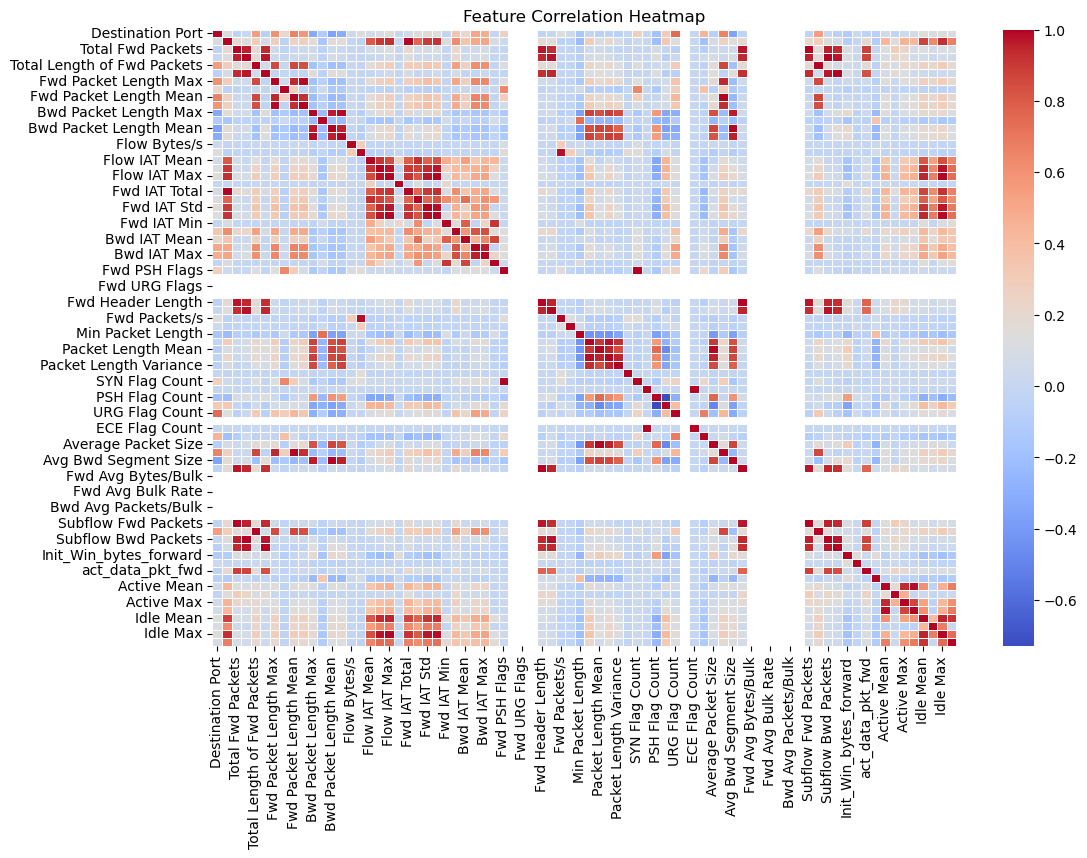

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: to avoid plot stacking
plt.clf()
plt.cla()
plt.close('all')

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, ax=ax)
ax.set_title("Feature Correlation Heatmap")

# Detect Streamlit runtime
def is_running_in_streamlit():
    try:
        import streamlit.runtime.scriptrunner.script_run_context as st_context
        return st_context.get_script_run_ctx() is not None
    except:
        return False

in_streamlit = is_running_in_streamlit()

# Show plot in correct environment
if in_streamlit:
    import streamlit as st
    st.pyplot(fig)
else:
    plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode target
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [11]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [12]:
df.drop(columns=to_drop, inplace=True)

In [13]:
# Split features/target
X = df.drop('Label', axis=1)
y = df['Label']

In [14]:
# Check for NaNs
print("NaNs in X:", X.isna().sum().sum())

# Check for Infs
print("Infs in X:", np.isinf(X).sum().sum())

# Optional: Check extreme large values
print("Max value in X:", X.max().max())

NaNs in X: 4
Infs in X: 64
Max value in X: inf


In [15]:
# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
# Drop rows with NaNs
X.dropna(inplace=True)

In [17]:
y = y[X.index]  # So labels match after dropping rows

In [18]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2, ...)

In [21]:
# Predict
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19538
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



In [22]:
df = df.loc[X.index]
y = y.loc[X.index]

In [23]:
# Get probability for the 'DDoS' class (assuming it's class 1)
probs = model.predict_proba(X_scaled)[:, 1]

# Add as 'anomaly_score' (higher means more likely to be DDoS)
df['anomaly_score'] = probs

# Predict labels
df['anomaly'] = model.predict(X_scaled)

# Show results
print(df[['anomaly_score', 'anomaly']].head())

   anomaly_score  anomaly
0   1.064444e-06        0
1   5.355052e-07        0
2   5.130270e-07        0
3   6.576944e-07        0
4   1.064444e-06        0


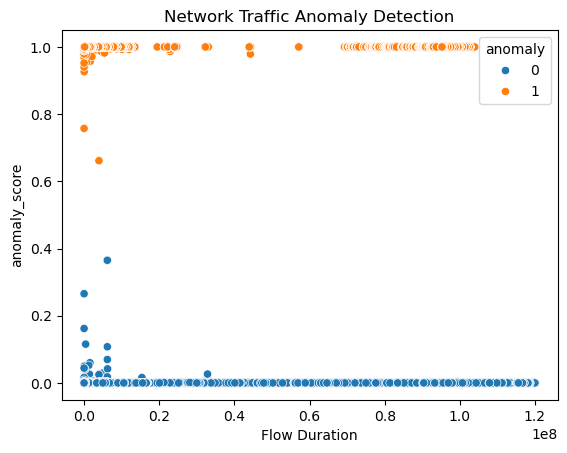

In [24]:
import os

fig, ax = plt.subplots()
sns.scatterplot(data=df, x='Flow Duration', y='anomaly_score', hue='anomaly')
ax.set_title("Network Traffic Anomaly Detection")
if "streamlit" in os.environ.get("PYTHONPATH", "").lower():
    st.pyplot(fig)
else:
    plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(df['Label'], df['anomaly'])
print(cm)

[[ 97685      1]
 [     3 128022]]


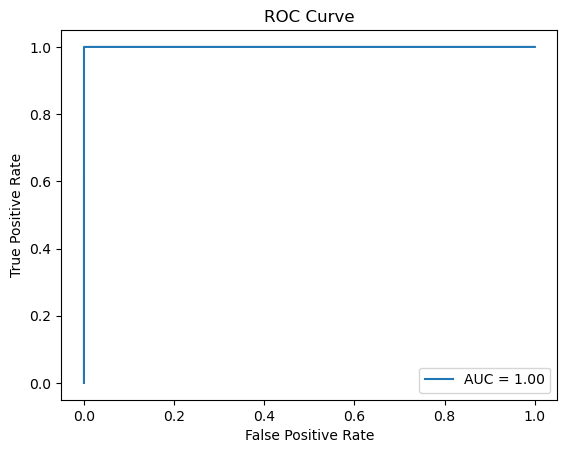

In [26]:
# ROC Curve
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(df['Label'], df['anomaly_score'])
ax.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
if in_streamlit:
    st.pyplot(fig)
else:
    plt.show()

In [27]:
from sklearn.impute import SimpleImputer

# Fill NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

C:\Users\rosel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rosel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\rosel\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rosel\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

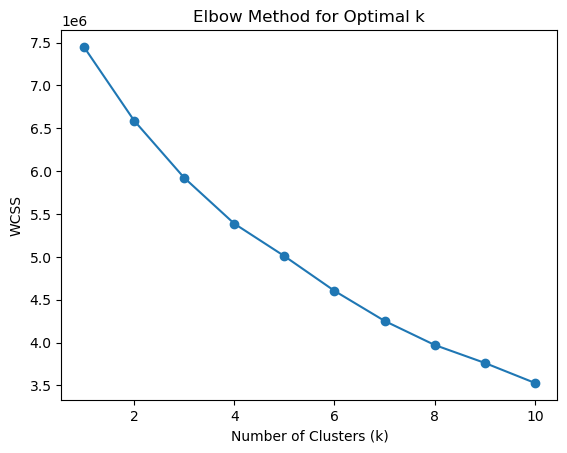

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

wcss = []  # Within-Cluster Sum of Squares

for k in range(1, 11):  # Try K values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Store WCSS for each k

# Plot Elbow Curve
fig, ax = plt.subplots()
ax.plot(range(1, 11), wcss, marker='o')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('WCSS')
ax.set_title('Elbow Method for Optimal k')
if in_streamlit:
    st.pyplot(fig)
else:
    plt.show()

In [30]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)  # Assign cluster labels

df['Cluster'] = clusters  # Add cluster labels to your original dataset

C:\Users\rosel\AppData\Local\Temp\ipykernel_5220\733616035.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


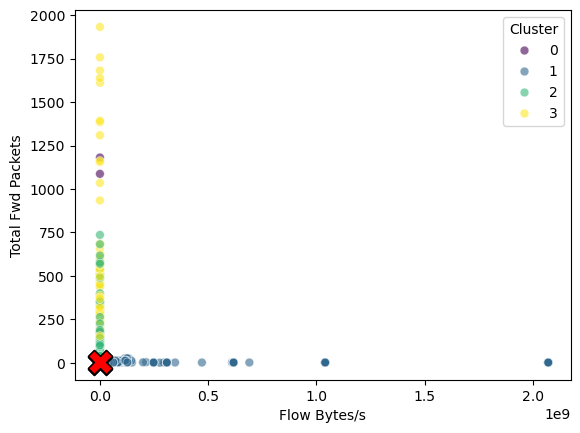

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))  # Create figure and axes

# Optional: Clear previous figures
plt.close('all')

# Plot the clusters with transparency and custom size
sns.scatterplot(
    x=df['Flow Bytes/s'],
    y=df['Total Fwd Packets'],
    hue=df['Cluster'],
    palette='viridis',
    alpha=0.6,  # 🔸 transparency
    s=40        # 🔸 marker size
)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=300,         # 🔸 bigger size
    c='red',
    marker='X',
    edgecolors='black',
    label='Centroids'
)

# Enhancements
ax.set_title('K-Means Clustering of Network Traffic with Centroids')
ax.set_xlabel('Flow Bytes/s')
ax.set_ylabel('Total Fwd Packets')

ax.grid(True, linestyle='--', alpha=0.5)  # 🧭 grid for clarity
ax.set_xscale('log') 

ax.legend()
fig.tight_layout()
if in_streamlit:
    st.pyplot(fig)
else:
    plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_)), param_grid=params, scoring='accuracy', cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=2, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [33]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


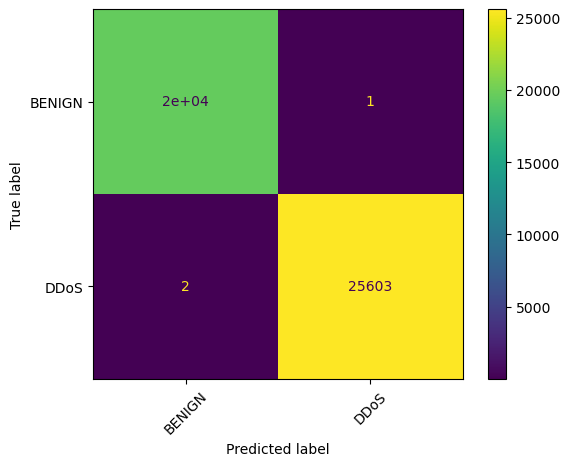

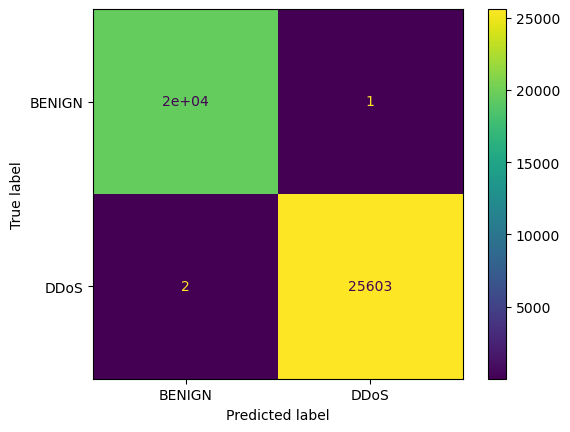

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# Optional: to avoid plot stacking
plt.clf()
plt.cla()
plt.close('all')

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=le.classes_, 
    xticks_rotation=45
)
disp.plot()
if in_streamlit:
    st.pyplot(fig)
else:
    plt.show()

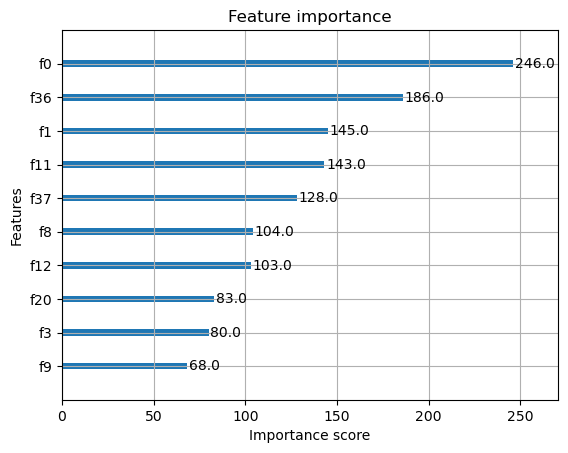

In [35]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)
if in_streamlit:
    st.pyplot(fig)
else:
    plt.show()

In [36]:
# Get actual feature names
feature_names = X.columns

# Create a mapping
feature_mapping = {f"f{i}": name for i, name in enumerate(feature_names)}
print(feature_mapping)

{'f0': 'Destination Port', 'f1': 'Flow Duration', 'f2': 'Total Fwd Packets', 'f3': 'Total Length of Fwd Packets', 'f4': 'Fwd Packet Length Max', 'f5': 'Fwd Packet Length Min', 'f6': 'Bwd Packet Length Max', 'f7': 'Bwd Packet Length Min', 'f8': 'Flow Bytes/s', 'f9': 'Flow Packets/s', 'f10': 'Flow IAT Mean', 'f11': 'Flow IAT Min', 'f12': 'Fwd IAT Min', 'f13': 'Bwd IAT Total', 'f14': 'Bwd IAT Mean', 'f15': 'Bwd IAT Std', 'f16': 'Fwd PSH Flags', 'f17': 'Bwd PSH Flags', 'f18': 'Fwd URG Flags', 'f19': 'Bwd URG Flags', 'f20': 'Bwd Packets/s', 'f21': 'Min Packet Length', 'f22': 'Max Packet Length', 'f23': 'FIN Flag Count', 'f24': 'RST Flag Count', 'f25': 'PSH Flag Count', 'f26': 'ACK Flag Count', 'f27': 'URG Flag Count', 'f28': 'CWE Flag Count', 'f29': 'Down/Up Ratio', 'f30': 'Fwd Avg Bytes/Bulk', 'f31': 'Fwd Avg Packets/Bulk', 'f32': 'Fwd Avg Bulk Rate', 'f33': 'Bwd Avg Bytes/Bulk', 'f34': 'Bwd Avg Packets/Bulk', 'f35': 'Bwd Avg Bulk Rate', 'f36': 'Init_Win_bytes_forward', 'f37': 'Init_Win_by

In [37]:
import pandas as pd

# Get importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Map them to actual names
named_importance = {feature_mapping[k]: v for k, v in importance.items()}

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(named_importance, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

                             Importance
Destination Port                  246.0
Init_Win_bytes_forward            186.0
Flow Duration                     145.0
Flow IAT Min                      143.0
Init_Win_bytes_backward           128.0
Flow Bytes/s                      104.0
Fwd IAT Min                       103.0
Bwd Packets/s                      83.0
Total Length of Fwd Packets        80.0
Flow Packets/s                     68.0


In [38]:
top_features = importance_df.head(10).index.tolist()

X_reduced = X[top_features]

# Then redo train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2, ...)

In [39]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19419
           1       1.00      1.00      1.00     25724

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



In [42]:
from tensorflow.keras import layers, Sequential, Input

input_dim = X.shape[1]

# Define encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
])

# Define decoder
decoder = Sequential([
    Input(shape=(8,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid'),
])

In [43]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6594/6594 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━

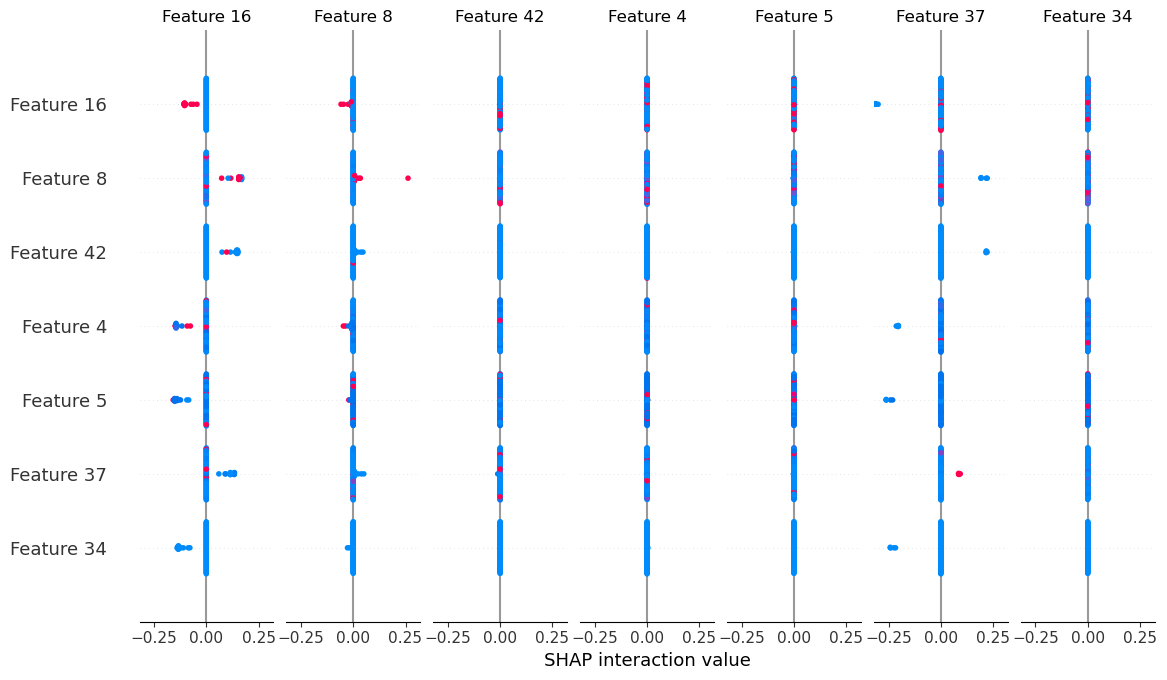

In [46]:
import shap

# Sample data for SHAP background and explanation
X_background = X_scaled[np.random.choice(X_scaled.shape[0], 100, replace=False)]
X_test_sample = X_scaled[:100]

explainer = shap.KernelExplainer(autoencoder.predict, X_background)
shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample)

In [47]:
import joblib
joblib.dump(autoencoder, "Classifying_Network_Traffic.keras")

['Classifying_Network_Traffic.keras']

In [51]:
import streamlit as st
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("Classifying_Network_Traffic.keras")

model.save("Classifying_Network_Traffic.keras")

In [52]:
st.title("Network Traffic Anomaly Detector")

# Add input fields based on top features
destination_port = st.number_input("Destination Port")
init_win_fwd = st.number_input("Init Win Bytes Forward")
flow_duration = st.number_input("Flow Duration")
flow_iat_min = st.number_input("Flow IAT Min")
init_win_bwd = st.number_input("Init Win Bytes Backward")
flow_bytes_per_sec = st.number_input("Flow Bytes/s")

2025-08-11 22:33:10.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.669 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.670 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.671 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.673 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:33:10.674 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [49]:
# Prediction
if st.button("Predict"):
    features = np.array([[destination_port, init_win_fwd, flow_duration, flow_iat_min,
                          init_win_bwd, flow_bytes_per_sec]])
    
    reconstructed = model.predict(features)
    mse = np.mean(np.power(features - reconstructed, 2))

    threshold = 0.01
    if mse > threshold:
        st.write("🔍 Prediction:", "❗ Anomaly Detected")
    else:
        st.write("🔍 Prediction:", "✅ Benign")

2025-08-11 22:30:04.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:30:04.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:30:04.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:30:04.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 22:30:04.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [50]:
del model
import gc
gc.collect()

35005